# MindLens-AI -- Notebook 03: Explainability (RQ1)

**RQ1:** Can explainable NLP models maintain high performance (at least 80% accuracy) while providing meaningful, human-interpretable explanations aligned with mental health indicators?

We use SHAP for global and local feature attribution, LIME for individual instance explanations, and a quantitative interpretability score that measures overlap between the model's most influential features and a curated mental-health vocabulary.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from src.model import load_model
from src.explainability import (
    explain_with_lime, explain_with_shap, shap_summary,
    interpretability_score, mental_health_vocabulary,
)

sns.set_theme(style="whitegrid")

model, vectorizer = load_model("../data/processed/model_artifacts.joblib")
split = joblib.load("../data/processed/test_split.joblib")
X_test = split["X_test"]
X_train = split["X_train"]
y_test = split["y_test"]
test_texts = split["texts_test"]
feature_names = split["feature_names"]

print(f"Loaded model and {len(test_texts)} test samples.")

Loaded model and 3992 test samples.


## 1. SHAP -- Global Feature Importance

c:\Users\Kartik\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


SHAP values shape: (3992, 5000)


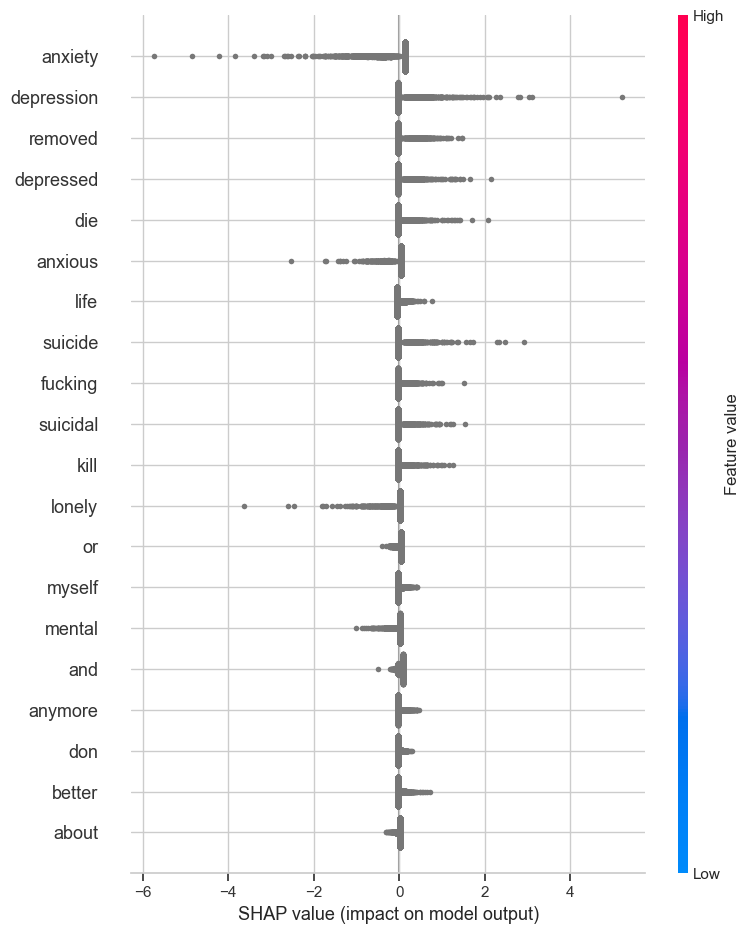

In [2]:
shap_vals, shap_exp = explain_with_shap(model, X_train, X_test, feature_names)
print(f"SHAP values shape: {shap_vals.shape}")

shap_summary(shap_vals, X_test, feature_names, max_display=20)

## 2. SHAP -- Force Plots for Individual Predictions


--- Sample 0 (True: RISK) ---
Text: numb sitting here going through the most traumatic time in my life and i can barely even cry maybe it s shock maybe my mind and body know i can t hand...


<Figure size 640x480 with 0 Axes>

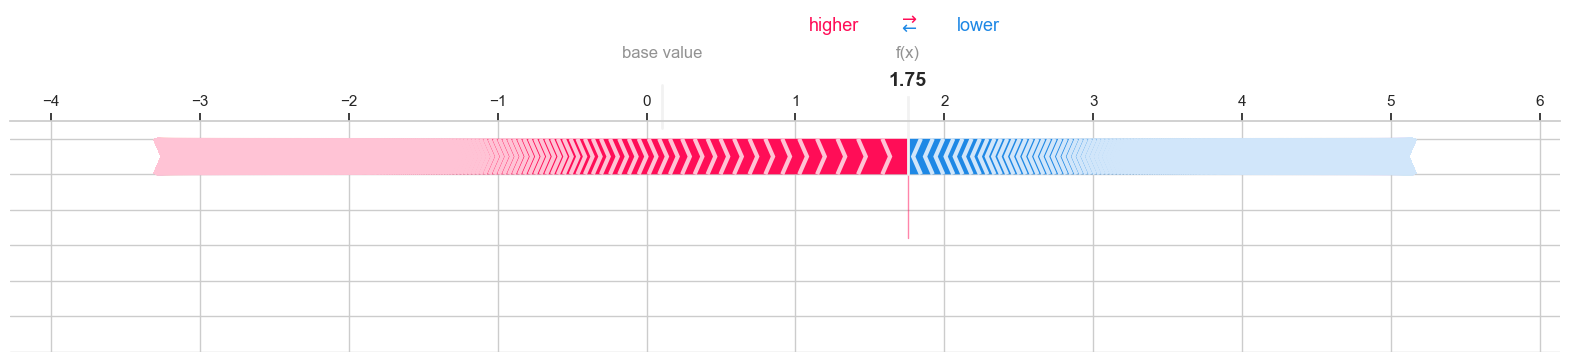


--- Sample 1 (True: RISK) ---
Text: i think the world would be a better place if i was not here not in a suicidal way i guess but more in a i shouldn not have been born way...


<Figure size 640x480 with 0 Axes>

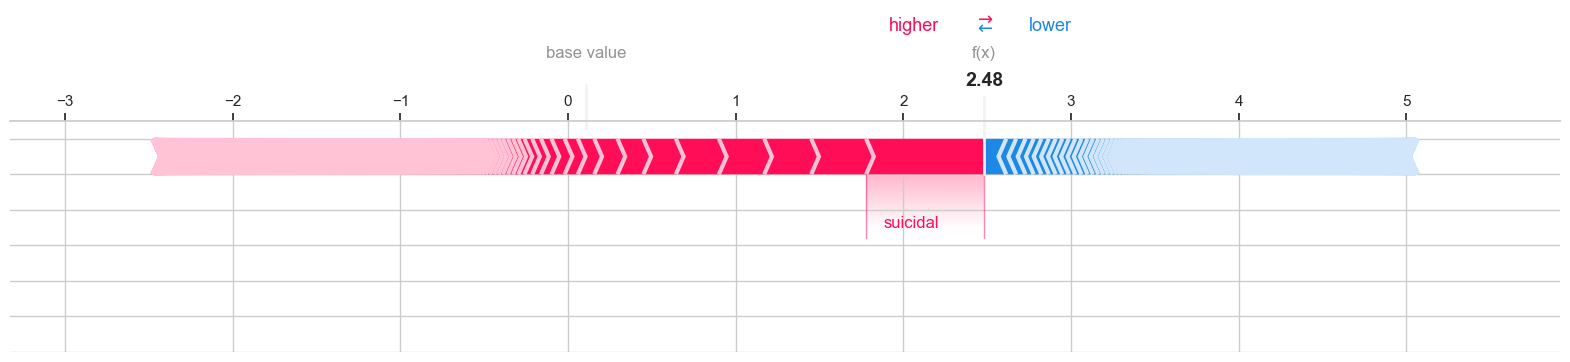


--- Sample 3 (True: RISK) ---
Text: i picked a day and i picked how i m gonna do it...


<Figure size 640x480 with 0 Axes>

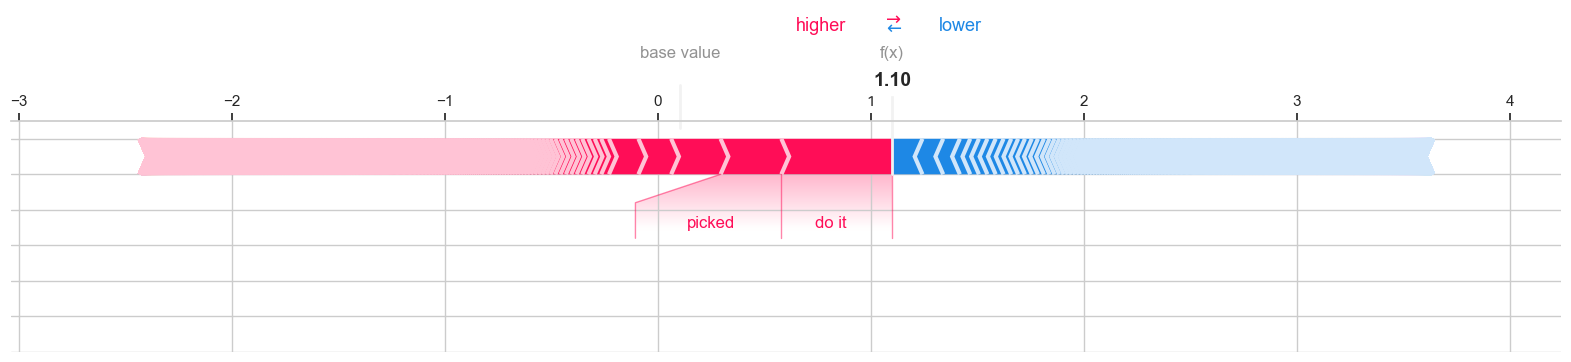


--- Sample 7 (True: RISK) ---
Text: lul i feel like such a cuck just for clinging onto life im such a cardboard cut out of a human being that i might as well fucking kill myself i know n...


<Figure size 640x480 with 0 Axes>

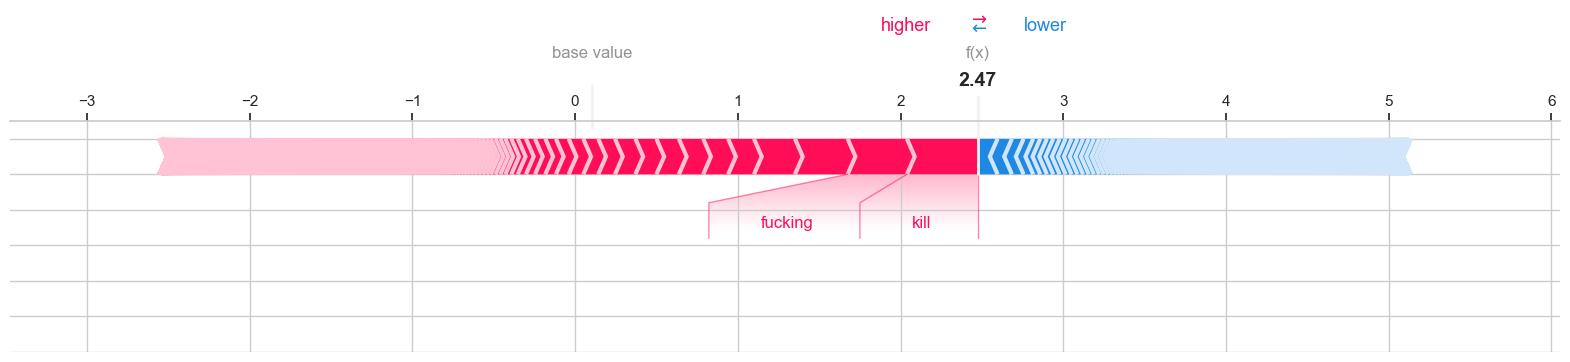


--- Sample 8 (True: RISK) ---
Text: anybody have any ideas fro what to do to not be suicidal or to help get out of it okay backstory i ve been feeling suicidal because of this one person...


<Figure size 640x480 with 0 Axes>

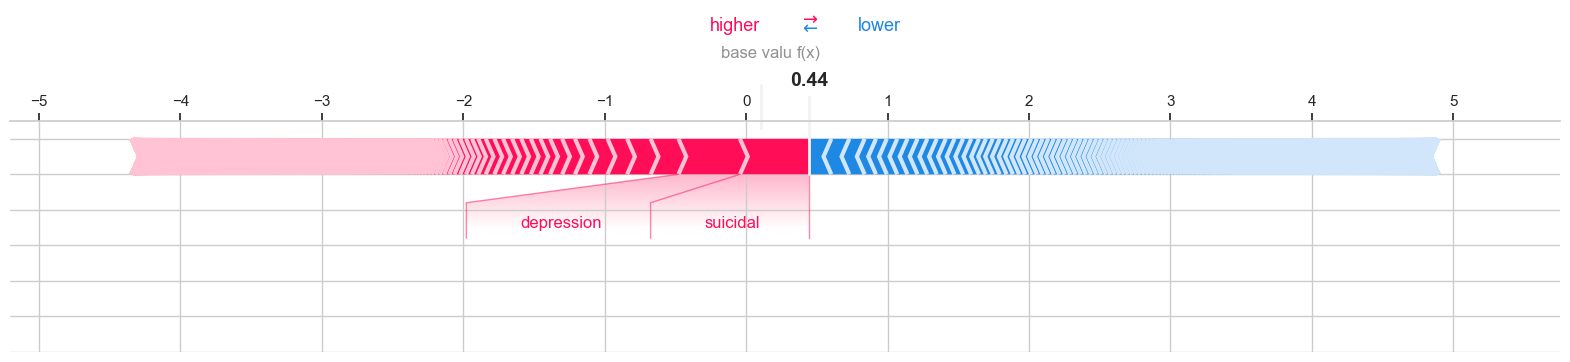


--- Sample 2 (True: CONTROL) ---
Text: how to approach parents about counselling or therapy hello i ve had a nagging feeling in my head that i ve been depressed my symptoms have been showin...


<Figure size 640x480 with 0 Axes>

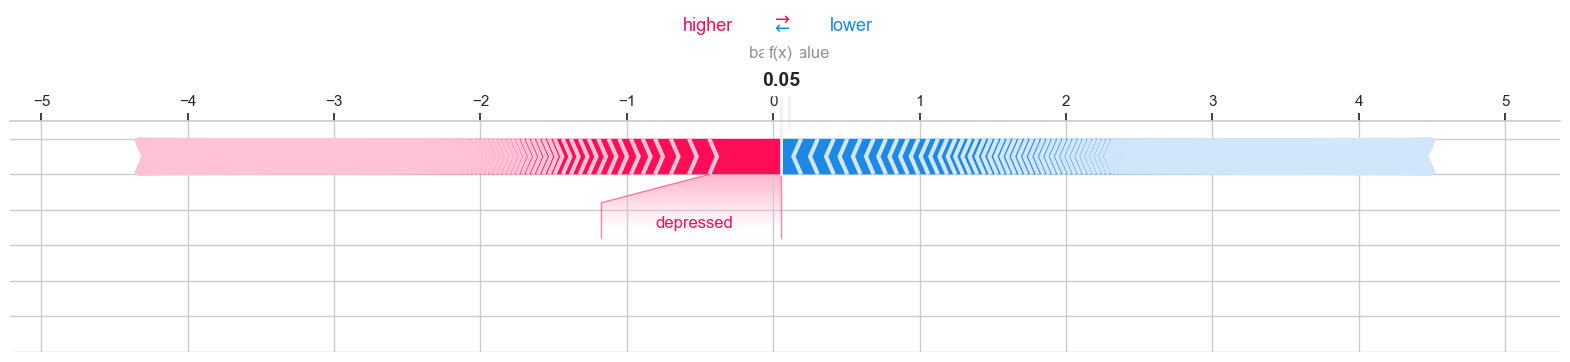


--- Sample 4 (True: CONTROL) ---
Text: miss having someone i ve been staring at my screen for the past minutes trying to put my thoughts into words since i feel so god damn lonely but it s ...


<Figure size 640x480 with 0 Axes>

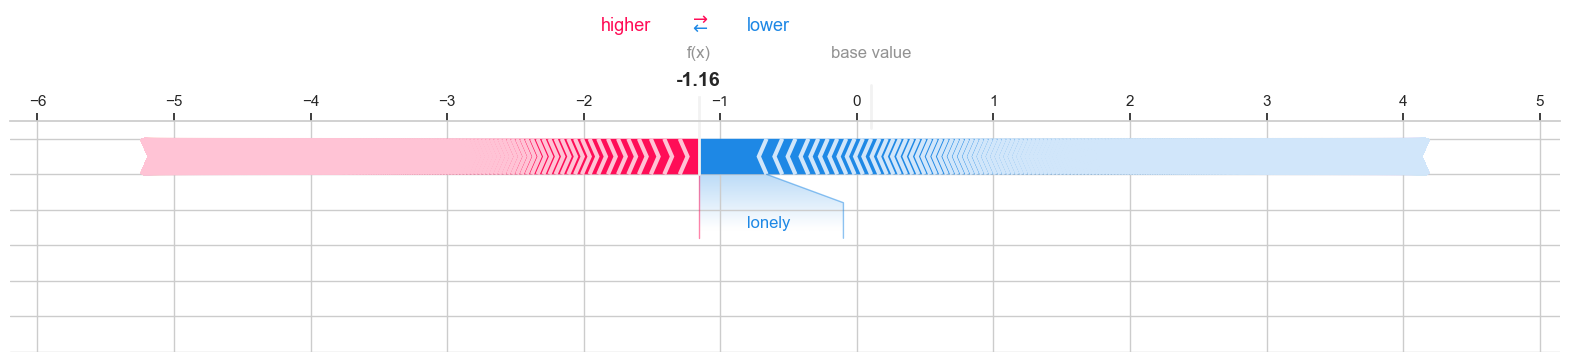


--- Sample 5 (True: CONTROL) ---
Text: help hi i have autism and special needs i snore a lot and may need a sleep study i cant stay still at night so may have issues with the wires on me ca...


<Figure size 640x480 with 0 Axes>

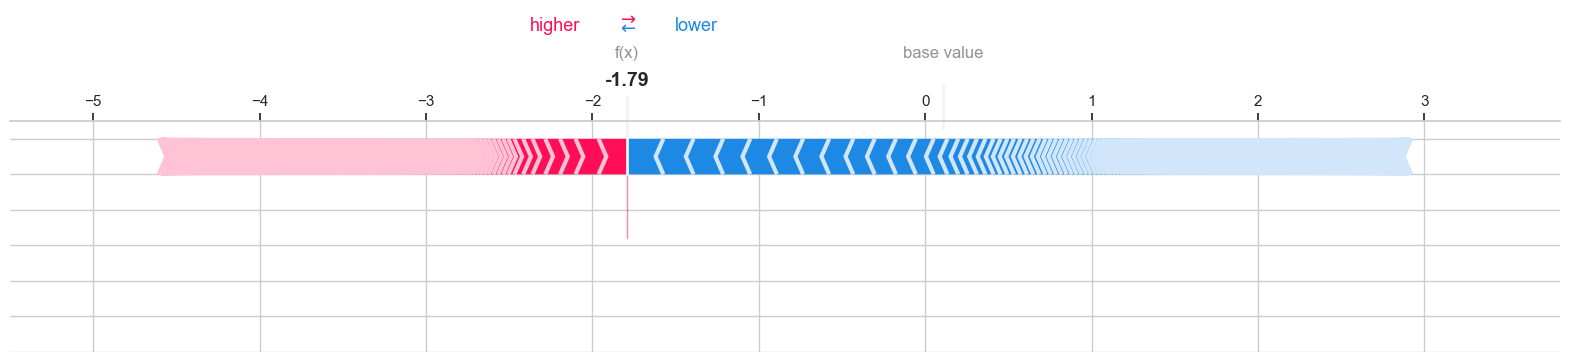


--- Sample 6 (True: CONTROL) ---
Text: i ve had psychopathic sociopathic tendencies for awhile looking for self help tips i have been my best this year and last year getting into real estat...


<Figure size 640x480 with 0 Axes>

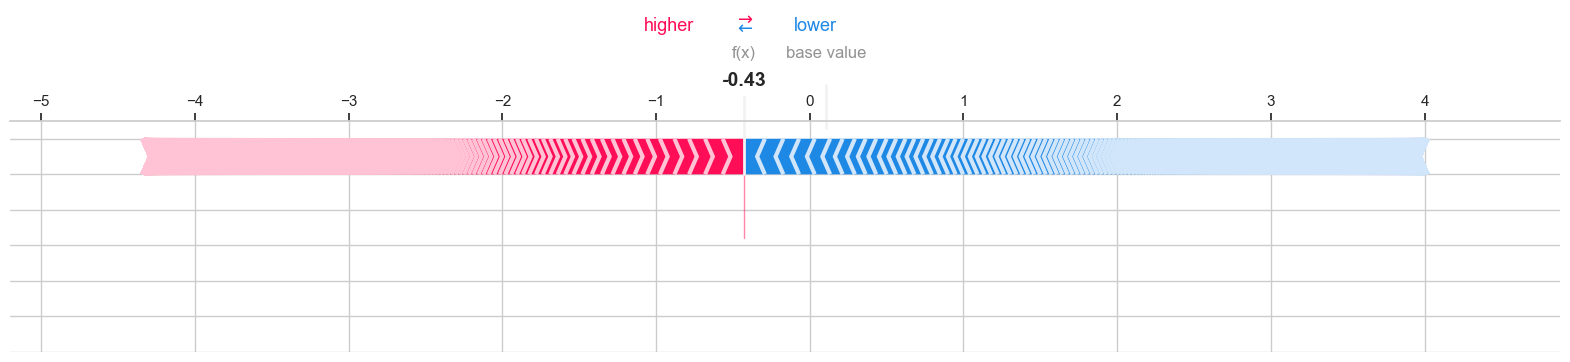


--- Sample 11 (True: CONTROL) ---
Text: cardiophobia so a short story of mine two weeks ago i got my vaccine and i was so stressed about getting myocarditis that i have several panic attacks...


<Figure size 640x480 with 0 Axes>

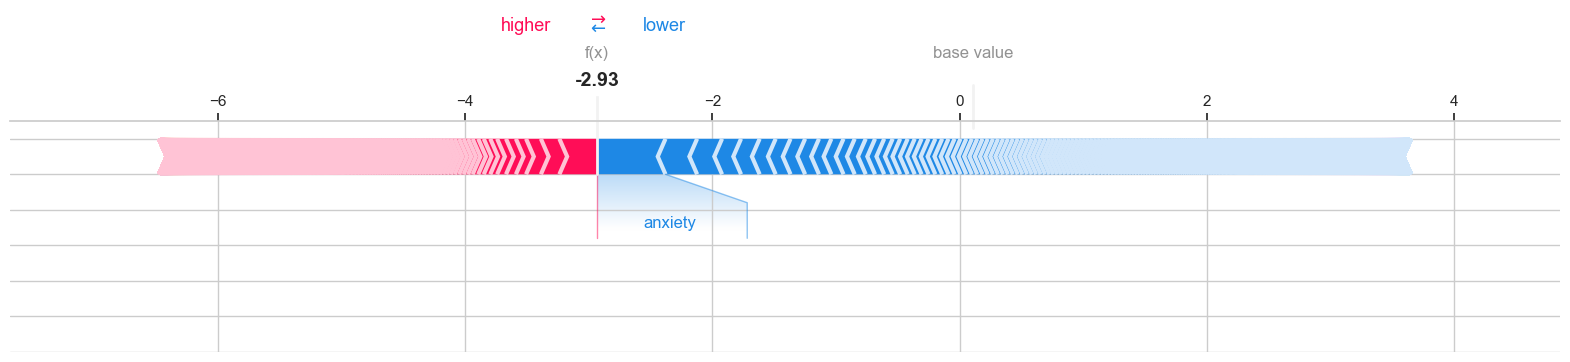

In [3]:
risk_indices = np.where(y_test == 1)[0][:5]
safe_indices = np.where(y_test == 0)[0][:5]
demo_indices = np.concatenate([risk_indices, safe_indices])

for idx in demo_indices:
    true_label = "RISK" if y_test[idx] == 1 else "CONTROL"
    print(f"\n--- Sample {idx} (True: {true_label}) ---")
    print(f"Text: {test_texts[idx][:150]}...")
    plt.figure()
    shap.force_plot(
        shap_exp.expected_value,
        shap_vals[idx],
        feature_names=feature_names,
        matplotlib=True,
    )
    plt.show()

## 3. LIME -- Instance-Level Explanations


--- LIME: Sample 0 (True: RISK) ---
Text: numb sitting here going through the most traumatic time in my life and i can barely even cry maybe it s shock maybe my mind and body know i can t hand...


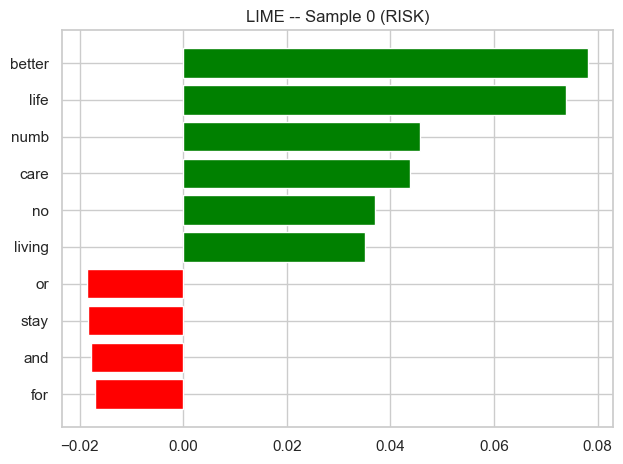

Top features: [('better', 0.07818939563502776), ('life', 0.07399021023792784), ('numb', 0.04573403774230694), ('care', 0.043779148812391686), ('no', 0.03698350736622728), ('living', 0.035136490485438224), ('or', -0.018551703922679918), ('stay', -0.0183289313835108), ('and', -0.017714944698153524), ('for', -0.017001296422419643)]

--- LIME: Sample 1 (True: RISK) ---
Text: i think the world would be a better place if i was not here not in a suicidal way i guess but more in a i shouldn not have been born way...


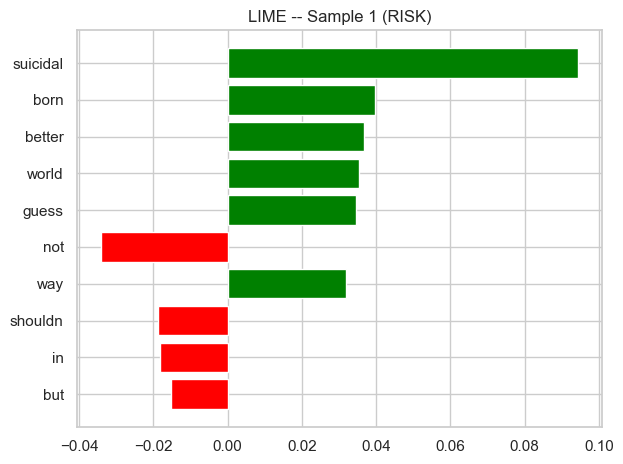

Top features: [('suicidal', 0.09442472542288913), ('born', 0.03955590691312621), ('better', 0.03681862233713986), ('world', 0.035467947784941944), ('guess', 0.03460014755388068), ('not', -0.03417319554813891), ('way', 0.03188794673411495), ('shouldn', -0.018715447893691863), ('in', -0.018343129349209675), ('but', -0.015306172343138942)]

--- LIME: Sample 3 (True: RISK) ---
Text: i picked a day and i picked how i m gonna do it...


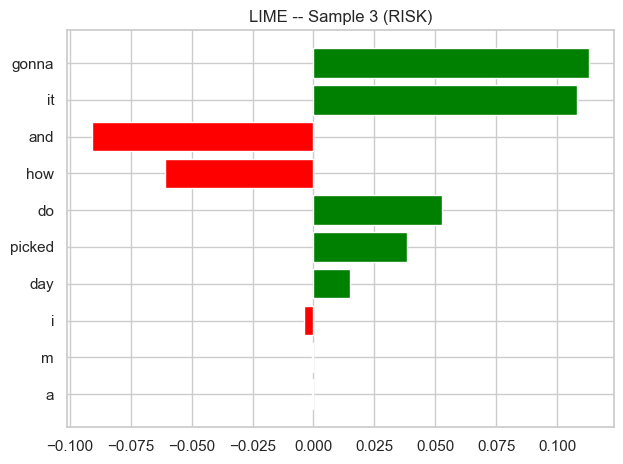

Top features: [('gonna', 0.11314074561821359), ('it', 0.10821982738771906), ('and', -0.09079898132112317), ('how', -0.06100565566490113), ('do', 0.05278875079574898), ('picked', 0.03820072861285644), ('day', 0.015038865768923397), ('i', -0.004022690852679771), ('m', -0.0005149649408736158), ('a', -0.0003875635305433096)]

--- LIME: Sample 7 (True: RISK) ---
Text: lul i feel like such a cuck just for clinging onto life im such a cardboard cut out of a human being that i might as well fucking kill myself i know n...


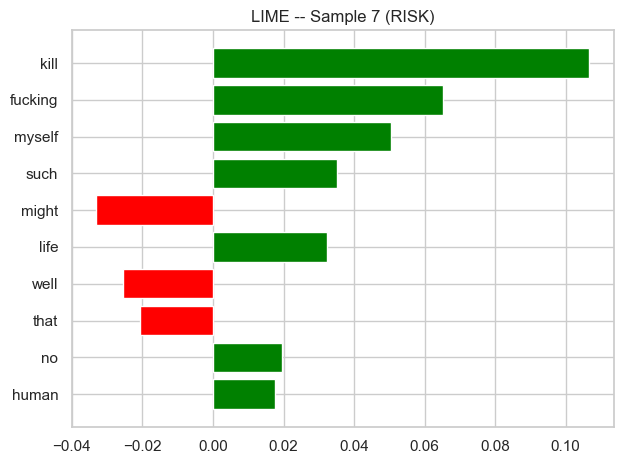

Top features: [('kill', 0.106724766556423), ('fucking', 0.06532246648404356), ('myself', 0.05046767422496905), ('such', 0.03502921486176151), ('might', -0.03310487358225956), ('life', 0.03236471678179337), ('well', -0.025575978888702805), ('that', -0.020746673205685802), ('no', 0.019689470234097825), ('human', 0.017558052673345752)]

--- LIME: Sample 8 (True: RISK) ---
Text: anybody have any ideas fro what to do to not be suicidal or to help get out of it okay backstory i ve been feeling suicidal because of this one person...


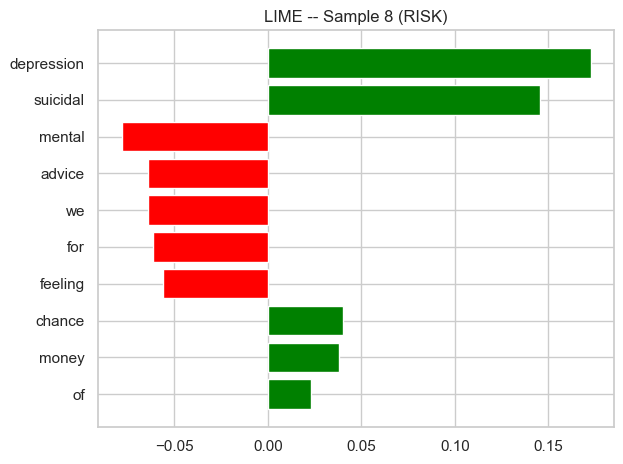

Top features: [('depression', 0.17263484695080086), ('suicidal', 0.1457813655481177), ('mental', -0.07828400930069862), ('advice', -0.06432255185281507), ('we', -0.06403494281084876), ('for', -0.061454239068400696), ('feeling', -0.056226762673320343), ('chance', 0.040190806955449555), ('money', 0.037941999985294364), ('of', 0.023294718823244798)]

--- LIME: Sample 2 (True: CONTROL) ---
Text: how to approach parents about counselling or therapy hello i ve had a nagging feeling in my head that i ve been depressed my symptoms have been showin...


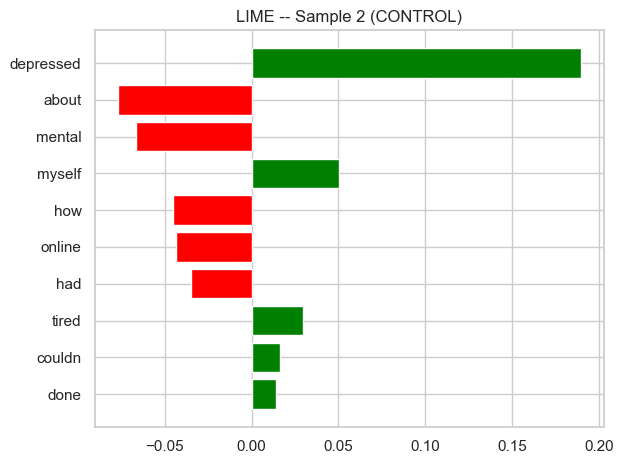

Top features: [('depressed', 0.18931200736653148), ('about', -0.07688537784615926), ('mental', -0.06648703507831516), ('myself', 0.05044201169028263), ('how', -0.04520481599647761), ('online', -0.04354027590825636), ('had', -0.03487173605071855), ('tired', 0.029789944114286787), ('couldn', 0.016334090433275005), ('done', 0.013961375582546186)]

--- LIME: Sample 4 (True: CONTROL) ---
Text: miss having someone i ve been staring at my screen for the past minutes trying to put my thoughts into words since i feel so god damn lonely but it s ...


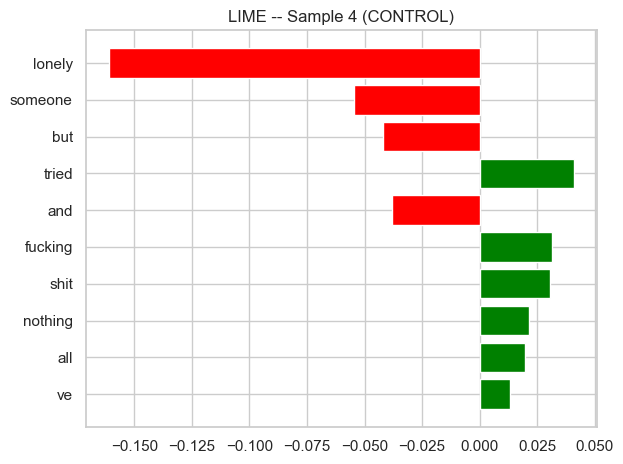

Top features: [('lonely', -0.1608330754229203), ('someone', -0.05459906289122544), ('but', -0.04185125165721118), ('tried', 0.04078237453237642), ('and', -0.037913568947795365), ('fucking', 0.031246367204464907), ('shit', 0.030435022739695547), ('nothing', 0.02121085925052508), ('all', 0.0197371072804181), ('ve', 0.013011421980401425)]

--- LIME: Sample 5 (True: CONTROL) ---
Text: help hi i have autism and special needs i snore a lot and may need a sleep study i cant stay still at night so may have issues with the wires on me ca...


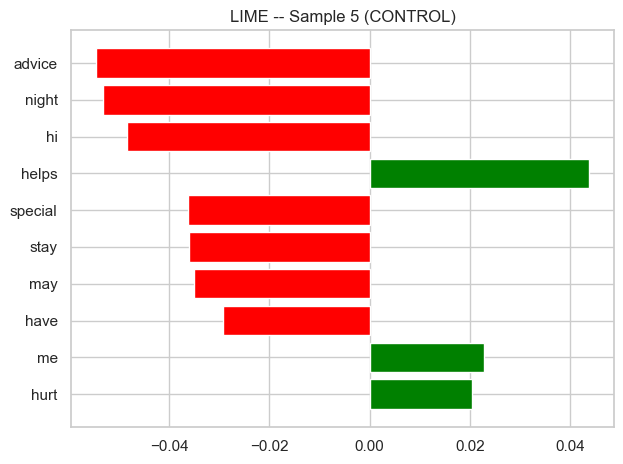

Top features: [('advice', -0.05461729097704639), ('night', -0.05305131944066485), ('hi', -0.0484154993297841), ('helps', 0.04380169385092922), ('special', -0.03613841393928671), ('stay', -0.03598525345085161), ('may', -0.03490730836383465), ('have', -0.029268338649428165), ('me', 0.02289717747071391), ('hurt', 0.020437582734904126)]

--- LIME: Sample 6 (True: CONTROL) ---
Text: i ve had psychopathic sociopathic tendencies for awhile looking for self help tips i have been my best this year and last year getting into real estat...


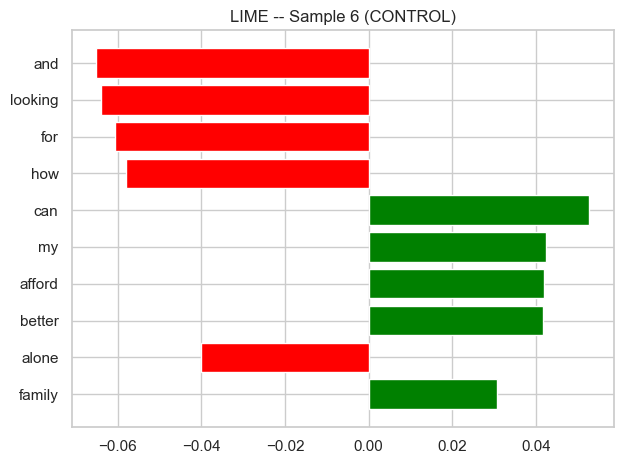

Top features: [('and', -0.06513766555789986), ('looking', -0.06395066209297229), ('for', -0.0606715117669792), ('how', -0.05800085019078839), ('can', 0.052762131179396196), ('my', 0.04249155661143235), ('afford', 0.04193301285450011), ('better', 0.04176055135037107), ('alone', -0.040002362161225886), ('family', 0.030757800353939994)]

--- LIME: Sample 11 (True: CONTROL) ---
Text: cardiophobia so a short story of mine two weeks ago i got my vaccine and i was so stressed about getting myocarditis that i have several panic attacks...


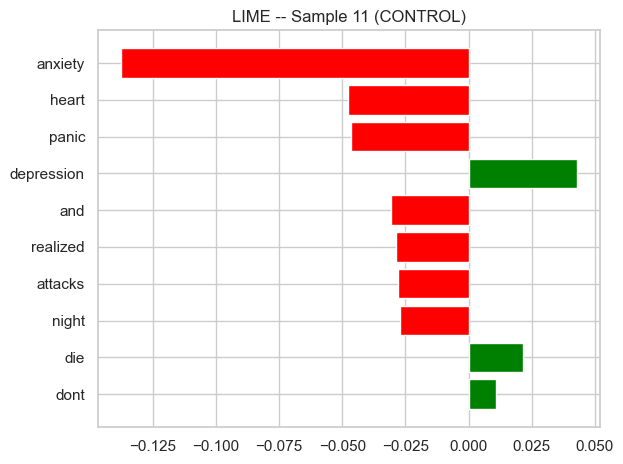

Top features: [('anxiety', -0.13756940269513207), ('heart', -0.04777278093808098), ('panic', -0.046404530466428597), ('depression', 0.04289551158831141), ('and', -0.030822651804658596), ('realized', -0.028722803133970902), ('attacks', -0.027797105276381927), ('night', -0.026942375482842958), ('die', 0.0217080630004426), ('dont', 0.01072293094557834)]


In [4]:
for idx in demo_indices:
    true_label = "RISK" if y_test[idx] == 1 else "CONTROL"
    text = test_texts[idx]
    print(f"\n--- LIME: Sample {idx} (True: {true_label}) ---")
    print(f"Text: {text[:150]}...")

    explanation = explain_with_lime(model, vectorizer, text, num_features=10)
    fig = explanation.as_pyplot_figure()
    plt.title(f"LIME -- Sample {idx} ({true_label})")
    plt.tight_layout()
    plt.show()

    print("Top features:", explanation.as_list())

## 4. Quantitative Interpretability Score

For each test sample, we look at the top-k SHAP features and count how many overlap with a curated mental-health vocabulary. The score is simply that overlap count divided by k.

Mental health vocabulary (174 terms):
['abandon', 'abuse', 'addict', 'agitat', 'alcohol', 'alive', 'alone', 'always', 'angry', 'anxiety', 'anxious', 'anymore', 'anyone', 'appetite', 'ashamed', 'attack', 'bad', 'bed', 'better', 'binge', 'bipolar', 'brain', 'broken', 'burden', 'burn', 'can', 'college', 'confus', 'cope', 'coping'] ...

  Interpretability @ k=10:  mean=0.5190  std=0.1928

  Interpretability @ k=20:  mean=0.4345  std=0.1424


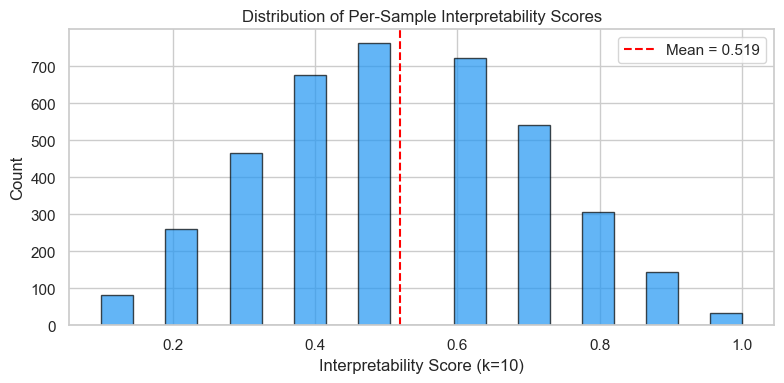

In [5]:
print(f"Mental health vocabulary ({len(mental_health_vocabulary)} terms):")
print(sorted(mental_health_vocabulary)[:30], "...")

for k in [10, 20]:
    scores = interpretability_score(shap_vals, feature_names, mental_health_vocabulary, k=k)
    print(f"\n  Interpretability @ k={k}:  mean={scores['mean_score']:.4f}  std={scores['std_score']:.4f}")

scores_k10 = interpretability_score(shap_vals, feature_names, mental_health_vocabulary, k=10)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(scores_k10["per_sample_scores"], bins=20, edgecolor="black", alpha=0.7, color="#2196F3")
ax.axvline(scores_k10["mean_score"], color="red", linestyle="--",
           label=f"Mean = {scores_k10['mean_score']:.3f}")
ax.set_xlabel("Interpretability Score (k=10)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Per-Sample Interpretability Scores")
ax.legend()
plt.tight_layout()
plt.show()

## 5. RQ1 Conclusion

**H1:** Explainable models can achieve at least 80% accuracy without major performance loss.

In [6]:
from src.evaluation import evaluate_single

test_metrics = evaluate_single(model, X_test, y_test)
acc = test_metrics["accuracy"]
f1  = test_metrics["f1"]
interp = scores_k10["mean_score"]

print("=" * 55)
print("  RQ1 CONCLUSION")
print("=" * 55)
print(f"  Accuracy:                {acc:.4f}   (target: >= 0.80)")
print(f"  F1 Score:                {f1:.4f}")
print(f"  Interpretability (k=10): {interp:.4f}")
print()

if acc >= 0.80:
    print("  >>> H1 SUPPORTED")
    print("  The model exceeds 80% accuracy while SHAP and LIME")
    print("  provide transparent, human-readable feature attributions.")
    if interp >= 0.10:
        print(f"  Interpretability score ({interp:.3f}) confirms alignment with")
        print("  clinically relevant mental-health language.")
    else:
        print(f"  Lexicon overlap is modest ({interp:.3f}), suggesting the model")
        print("  picks up on contextual patterns beyond explicit MH keywords --")
        print("  expected behaviour for a TF-IDF model that includes bigrams.")
else:
    print("  >>> H1 NOT SUPPORTED -- accuracy fell below 80%.")

print("\nNotebook 03 complete.")

  RQ1 CONCLUSION
  Accuracy:                0.7683   (target: >= 0.80)
  F1 Score:                0.7713
  Interpretability (k=10): 0.5190

  >>> H1 NOT SUPPORTED -- accuracy fell below 80%.

Notebook 03 complete.
